In [173]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['figure.figsize'] = (5, 5)

In [174]:
from gensim.corpora import Dictionary

config = {
    "inputData": "/home/jvdzwaan/data/dilipad/CAP/vragenuurtje/*",
    "outDir": "/home/jvdzwaan/data/dilipad/results/all_years-adj-cabinets_selected-parties/{}",
    "nTopics": 100
}

# topic dict inlezen
topicDict = Dictionary.load(config.get('outDir').format('topicDict.dict'))
print topicDict

Dictionary(38145 unique tokens: [u'baangarantie', u'ontwerprichtlijn', u'scheuring', u'cli\xebntniveau', u'leveringsakte']...)


In [175]:
import glob
import re
import os
import codecs
import gensim

# corpus maken
text_files = glob.glob(config.get('inputData'))
#print len(text_files)

text_ids = [int(re.search(r'\d+', f).group()) for f in text_files]
text_ids.sort()
#print text_ids

texts = []
for text_id in text_ids:
    if text_id != 1351: # text without main code
        with codecs.open("/home/jvdzwaan/data/dilipad/CAP/vragenuurtje/{}.txt".format(text_id), 'rb', encoding='utf-8') as f:
            lines = f.readlines()
        nouns = lines[0].split()
        #filtered = [n for n in nouns if n in topicDict.values()]
        #with codecs.open("/home/jvdzwaan/data/dilipad/CAP/vragenuurtje_filtered/{}.txt".format(text_id), 'wb', encoding='utf-8') as f:
        #    f.write(' '.join(filtered))
        texts.append(nouns)
        #print nouns

corpus = [topicDict.doc2bow(text) for text in texts]
#print corpus
corpus_dense = gensim.matutils.corpus2dense(corpus, len(topicDict), num_docs=len(texts))
print corpus_dense.shape
# gensim.matutils.corpus2dense als input voor sklearn

(38145, 834)


In [ ]:
#print topicDict.values()

In [176]:
# get class labels
data = pd.read_excel('/home/jvdzwaan/data/dilipad/CAP/PA OQ COMPLETE.xls', index_col=0)
data['main code'] = data.apply(lambda row: int(row['subcode']) / 100, axis=1)
print text_ids[0], text_ids[-1]
data = data.loc[text_ids]
class_labels = data[data['main code'] != 0]['main code'].values

#print class_labels
print len(class_labels)

672 1507
834


In [177]:
from sklearn.feature_extraction.text import TfidfVectorizer

def split(s):
    return s.split()

filtered_texts = []
for text_id in text_ids:
    if text_id != 1351: # text without main code
        with codecs.open("/home/jvdzwaan/data/dilipad/CAP/vragenuurtje_filtered/{}.txt".format(text_id), 'rb', encoding='utf-8') as f:
            filtered_texts.append(f.read())

tf = TfidfVectorizer(analyzer=split)
tf = tf.fit_transform(filtered_texts)

In [178]:
print tf

  (0, 2060)	0.0623130395785
  (0, 2071)	0.0514445455574
  (0, 495)	0.0873270240847
  (0, 5408)	0.0650832519799
  (0, 4052)	0.329173533378
  (0, 4761)	0.075951746001
  (0, 3987)	0.0466429580329
  (0, 254)	0.0661634534654
  (0, 4668)	0.0673466803188
  (0, 5109)	0.0822933833444
  (0, 3857)	0.0701168927203
  (0, 2072)	0.0570065420175
  (0, 3492)	0.0736883176622
  (0, 530)	0.0717746162693
  (0, 3529)	0.174654048169
  (0, 2770)	0.0686546769218
  (0, 1964)	0.240198444958
  (0, 5094)	0.0701168927203
  (0, 5201)	0.343273384609
  (0, 3835)	0.0575583877832
  (0, 5202)	0.0623130395785
  (0, 1901)	0.0787219584025
  (0, 1902)	0.0822933833444
  (0, 966)	0.0873270240847
  (0, 2967)	0.0650832519799
  :	:
  (833, 5292)	0.270965909313
  (833, 1505)	0.0841520861148
  (833, 716)	0.0964918534269
  (833, 2713)	0.0774288030937
  (833, 2024)	0.0607114336613
  (833, 2963)	0.0720013498724
  (833, 4437)	0.0763789519927
  (833, 3131)	0.157112979373
  (833, 923)	0.165097671297
  (833, 3240)	0.130665019725
  (833, 5

In [272]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, f1_score, hamming_loss, precision_score, recall_score

performance = pd.DataFrame(np.zeros((5, 4)), columns=['accuracy', 'precision', 'recall', 'F1'], index=range(5))

skf = StratifiedKFold(class_labels, 5, random_state=345)
for it, (train, test) in enumerate(skf):
    train_X = [filtered_texts[i] for i in train]
    train_Y = [class_labels[i] for i in train]
    test_X = [filtered_texts[i] for i in test]
    test_Y = [class_labels[i] for i in test]
    
    clf = make_pipeline(TfidfVectorizer(analyzer=split),
                       MultinomialNB())
    clf.fit(train_X, train_Y)

    pred = clf.predict(test_X)
    #print len(pred), len(class_labels[test])
    
    #print class_labels[test]
    #print pred
    performance.loc[it, 'accuracy'] = accuracy_score(test_Y, pred)
    performance.loc[it, 'precision'] = precision_score(test_Y, pred, average='weighted')
    performance.loc[it, 'recall'] = recall_score(test_Y, pred, average='weighted')
    performance.loc[it, 'F1'] = f1_score(test_Y, pred, average='weighted')
    
performance.to_csv('/home/jvdzwaan/data/dilipad/CAP/performance_nb.csv', encoding='utf-8')
performance

,accuracy,precision,recall,F1
0,0.445087,0.413674,0.445087,0.362879
1,0.415205,0.368686,0.415205,0.344547
2,0.488095,0.480417,0.488095,0.418525
3,0.463415,0.485890,0.463415,0.401963
4,0.424051,0.453595,0.424051,0.357244


In [271]:
from sklearn.svm import LinearSVC

performance = pd.DataFrame(np.zeros((5, 4)), columns=['accuracy', 'precision', 'recall', 'F1'], index=range(5))

skf = StratifiedKFold(class_labels, 5, random_state=345)
for it, (train, test) in enumerate(skf):
    train_X = [filtered_texts[i] for i in train]
    train_Y = [class_labels[i] for i in train]
    test_X = [filtered_texts[i] for i in test]
    test_Y = [class_labels[i] for i in test]
    
    clf = make_pipeline(TfidfVectorizer(analyzer=split),
                        LinearSVC(class_weight='auto'))
    clf.fit(train_X, train_Y)

    pred = clf.predict(test_X)
    #print len(pred), len(class_labels[test])
    
    #print class_labels[test]
    #print pred
    
    performance.loc[it, 'accuracy'] = accuracy_score(test_Y, pred)
    performance.loc[it, 'precision'] = precision_score(test_Y, pred, average='weighted')
    performance.loc[it, 'recall'] = recall_score(test_Y, pred, average='weighted')
    performance.loc[it, 'F1'] = f1_score(test_Y, pred, average='weighted')
    
performance.to_csv('/home/jvdzwaan/data/dilipad/CAP/performance_svm.csv', encoding='utf-8')
performance

,accuracy,precision,recall,F1
0,0.595376,0.563234,0.595376,0.558710
1,0.602339,0.616954,0.602339,0.591722
2,0.630952,0.596047,0.630952,0.598463
3,0.634146,0.680253,0.634146,0.634989
4,0.550633,0.551798,0.550633,0.542064


In [267]:
(2*0.563234*0.595376)/(0.563234+0.595376)

0.5788591605182073

In [182]:
clf = make_pipeline(TfidfVectorizer(analyzer=split),
                        LinearSVC(class_weight='auto'))
clf.fit(filtered_texts, class_labels)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(analyzer=<function split at 0x7fd829e11488>, binary=False,
        charset=None, charset_error=None, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_...ling=1, loss='l2', multi_class='ovr', penalty='l2',
     random_state=None, tol=0.0001, verbose=0))])

In [183]:
usefulness_data = pd.read_csv(config.get('outDir').format('topics_100_data.csv'), index_col=0, encoding='utf-8')
#usefulness_data

In [184]:
res = clf.predict(usefulness_data['words'])
print res
#print usefulness_data['cap']

[19  3 19 16 10  3 10  3 15 15 19 15  6 15 16 20 12 12 19 17 14  3  5  3 12
  5  4 20 19 15  6 19  2  2 13 19 15  4  1 14  2 13 15 19  1  2  7 15  1  6
 19 19 15 14 13 12  4  2  3  5 20 17  2  2 20 19  6  8  8 16 19 13 19 20 12
 13 12 15  8 16  6  3  2  3 10  7 20 10 19 21 12 17 12 20  3 12  6  1  2 13]


In [185]:
usefulness_data['cap_svm'] = res
usefulness_data.to_csv(config.get('outDir').format('topics_100_data.csv'), encoding='utf-8')
usefulness_data

,words,usefulness_A,usefulness_B,usefulness_C,cap,ca,cp,cv,npmi,uci,umass,mean_usefulness,usefulness,cap_svm
0,draagvlak herindeling stad inwoner samenwerkin...,3,3,3,14,0.16317,0.16612,0.44352,-0.16858,-5.35646,-2.73341,3.000000,3,19
1,risico systeem effect voordeel prikkel nadeel ...,1,3,3,20,0.12887,-0.09130,0.56865,-0.20210,-6.22748,-2.85187,2.333333,3,3
2,argument bezwaar redenering argumentatie grond...,1,3,3,20,0.08233,0.02394,0.52150,-0.26799,-7.61658,-2.13820,2.333333,3,19
3,besluit oordeel notitie procedure beslissing b...,1,1,2,NaN,0.07648,-0.27249,0.57542,-0.31456,-8.72293,-4.78655,1.333333,1,16
4,auto weg verkeer kilometerheffing waterstaat f...,3,3,3,10,0.11367,-0.17543,0.56065,-0.18293,-5.79123,-4.71433,3.000000,3,10
5,ondersteuning aanbesteding hulp dienst budget ...,3,2,3,3,0.06760,-0.46730,0.57835,-0.23918,-6.72214,-7.49376,2.666667,3,3
6,grens buitenland verkeer principe lijn verschi...,1,1,1,NaN,0.22065,0.04654,0.32548,-0.27762,-7.77876,-2.54380,1.000000,1,10
7,ziekenhuis verzekeraar zorgverzekeraar premie ...,3,3,3,3,0.07175,-0.09219,0.69189,-0.18560,-6.03437,-2.29786,3.000000,3,3
8,bewindsman aanpak uitvoering resultaat inzet r...,1,1,2,NaN,0.11291,-0.23389,0.51310,-0.29855,-8.39318,-4.63982,1.333333,1,15
9,regel regelgeving fraude schip bureaucratie we...,1,2,2,NaN,0.13010,-0.38127,0.61924,-0.27872,-8.00416,-2.50298,1.666667,2,15


Confusion Matrix:

Predicted  0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0   ...     13.0  \
Actual                                                        ...            
0.0          0    0    0    0    0    0    0    0    0    0   ...        0   
1.0          1    3    0    0    0    0    0    0    0    0   ...        0   
2.0          5    0    3    0    0    0    0    0    0    1   ...        0   
3.0          0    0    0    5    0    0    0    0    0    0   ...        1   
4.0          0    0    0    0    2    0    0    1    0    0   ...        0   
5.0          0    0    0    0    0    2    0    0    0    0   ...        0   
6.0          2    0    0    0    0    0    2    0    0    0   ...        0   
7.0          1    0    0    0    0    0    0    1    0    0   ...        0   
8.0          2    0    0    0    0    0    0    0    1    0   ...        0   
9.0          0    0    0    0    0    0    0    0    0    0   ...        0   
10.0         2    0    0    0    0    0    0 

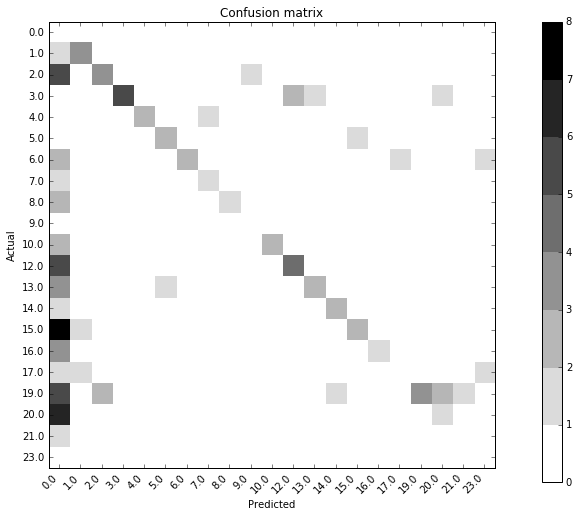

In [186]:
from pandas_confusion import ConfusionMatrix
cm = ConfusionMatrix(usefulness_data['cap_svm'], usefulness_data['cap'].fillna(0))
cm.print_stats()
#print cm
cm.plot()

Confusion Matrix:

Predicted  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  10.0   ...     13.0  \
Actual                                                         ...            
1.0          3    0    0    0    0    0    0    0    0     0   ...        0   
2.0          0    3    0    0    0    0    0    0    1     0   ...        0   
3.0          0    0    5    0    0    0    0    0    0     0   ...        1   
4.0          0    0    0    2    0    0    1    0    0     0   ...        0   
5.0          0    0    0    0    2    0    0    0    0     0   ...        0   
6.0          0    0    0    0    0    2    0    0    0     0   ...        0   
7.0          0    0    0    0    0    0    1    0    0     0   ...        0   
8.0          0    0    0    0    0    0    0    1    0     0   ...        0   
9.0          0    0    0    0    0    0    0    0    0     0   ...        0   
10.0         0    0    0    0    0    0    0    0    0     2   ...        0   
12.0         0    0    0    0    

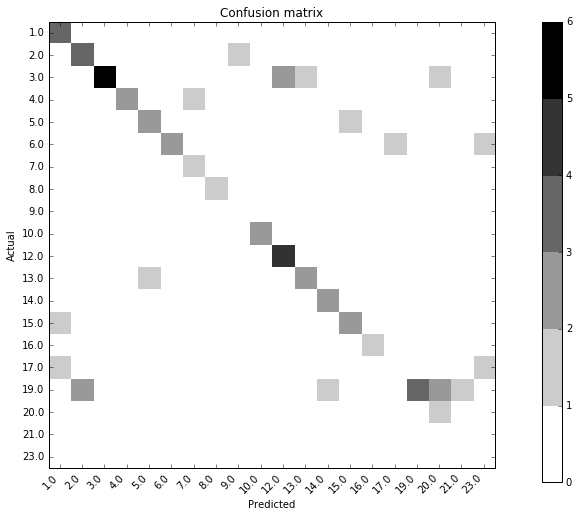

In [187]:
known = usefulness_data.dropna()
#known
cm = ConfusionMatrix(known['cap_svm'], known['cap'])
cm.print_stats()
#print cm
cm.plot()

In [188]:
topic2cap = dict(usefulness_data['cap_svm'])
print topic2cap

{0: 19, 1: 3, 2: 19, 3: 16, 4: 10, 5: 3, 6: 10, 7: 3, 8: 15, 9: 15, 10: 19, 11: 15, 12: 6, 13: 15, 14: 16, 15: 20, 16: 12, 17: 12, 18: 19, 19: 17, 20: 14, 21: 3, 22: 5, 23: 3, 24: 12, 25: 5, 26: 4, 27: 20, 28: 19, 29: 15, 30: 6, 31: 19, 32: 2, 33: 2, 34: 13, 35: 19, 36: 15, 37: 4, 38: 1, 39: 14, 40: 2, 41: 13, 42: 15, 43: 19, 44: 1, 45: 2, 46: 7, 47: 15, 48: 1, 49: 6, 50: 19, 51: 19, 52: 15, 53: 14, 54: 13, 55: 12, 56: 4, 57: 2, 58: 3, 59: 5, 60: 20, 61: 17, 62: 2, 63: 2, 64: 20, 65: 19, 66: 6, 67: 8, 68: 8, 69: 16, 70: 19, 71: 13, 72: 19, 73: 20, 74: 12, 75: 13, 76: 12, 77: 15, 78: 8, 79: 16, 80: 6, 81: 3, 82: 2, 83: 3, 84: 10, 85: 7, 86: 20, 87: 10, 88: 19, 89: 21, 90: 12, 91: 17, 92: 12, 93: 20, 94: 3, 95: 12, 96: 6, 97: 1, 98: 2, 99: 13}


In [189]:
def top10(row, n=10):
    #print list(row.sort_values(ascending=False).index[:10])
    return pd.Series(list(row.sort_values(ascending=False).index[:n]))

config = {
    "inputData": "/path/to/input/data/*",
    "outDir": "/home/jvdzwaan/data/dilipad/CAP/{}",
    "nTopics": 100
}

vragenuurtje_topics = pd.read_csv(config.get('outDir').format('theta_100.csv'), index_col=0, encoding='utf-8')
# add top 10 of topics estimated in text
vragenuurtje_topics[['topic1', 'topic2', 'topic3']] = vragenuurtje_topics.apply(lambda row: top10(row, 3), axis=1)
vragenuurtje_topics['cap_topic_1'] = vragenuurtje_topics.apply(lambda row: topic2cap[int(row['topic1'])], axis=1)
vragenuurtje_topics['cap_topic_2'] = vragenuurtje_topics.apply(lambda row: topic2cap[int(row['topic2'])], axis=1)
vragenuurtje_topics['cap_topic_3'] = vragenuurtje_topics.apply(lambda row: topic2cap[int(row['topic3'])], axis=1)
vragenuurtje_topics

,0,1,2,3,4,5,6,7,8,9,...,96,97,98,99,topic1,topic2,topic3,cap_topic_1,cap_topic_2,cap_topic_3
1000.txt,0.004274,0.004274,0.004274,0.004274,0.012821,0.004274,0.012821,0.029915,0.004274,0.004274,...,0.004274,0.004274,0.004274,0.004274,83,37,58,3,4,3
1001.txt,0.004717,0.004717,0.004717,0.014151,0.051887,0.023585,0.014151,0.004717,0.023585,0.014151,...,0.014151,0.004717,0.004717,0.004717,87,4,8,10,10,15
1002.txt,0.014286,0.004762,0.004762,0.004762,0.004762,0.004762,0.004762,0.004762,0.004762,0.004762,...,0.014286,0.004762,0.033333,0.004762,58,95,45,3,12,2
1003.txt,0.006410,0.006410,0.006410,0.006410,0.006410,0.044872,0.032051,0.006410,0.006410,0.006410,...,0.006410,0.006410,0.006410,0.006410,71,5,83,13,3,3
1004.txt,0.004587,0.004587,0.004587,0.004587,0.004587,0.004587,0.013761,0.022936,0.004587,0.032110,...,0.004587,0.004587,0.013761,0.004587,26,24,21,4,12,3
1005.txt,0.005618,0.005618,0.005618,0.005618,0.016854,0.028090,0.005618,0.028090,0.005618,0.005618,...,0.005618,0.005618,0.005618,0.005618,87,84,7,10,10,3
1006.txt,0.006579,0.006579,0.006579,0.006579,0.006579,0.019737,0.006579,0.006579,0.006579,0.019737,...,0.006579,0.046053,0.006579,0.006579,97,53,16,1,14,12
1007.txt,0.012295,0.004098,0.004098,0.020492,0.004098,0.004098,0.004098,0.004098,0.004098,0.004098,...,0.004098,0.004098,0.004098,0.004098,21,81,73,3,3,20
1008.txt,0.006579,0.006579,0.006579,0.059211,0.006579,0.006579,0.006579,0.006579,0.006579,0.006579,...,0.006579,0.006579,0.006579,0.006579,25,3,46,5,16,7
1009.txt,0.005263,0.005263,0.005263,0.005263,0.005263,0.005263,0.005263,0.005263,0.005263,0.005263,...,0.015789,0.005263,0.015789,0.005263,61,68,84,17,8,10


In [190]:
vragenuurtje_topics
question_ids = [int(text.replace('.txt', '')) -1 for text in vragenuurtje_topics.index]
cap_results['topic1'] = pd.Series(data=vragenuurtje_topics['cap_topic_1'].values, index=question_ids)
cap_results['topic2'] = pd.Series(data=vragenuurtje_topics['cap_topic_2'].values, index=question_ids)
cap_results['topic3'] = pd.Series(data=vragenuurtje_topics['cap_topic_3'].values, index=question_ids)
cap_results
#print vragenuurtje_topics['cap_topic_1']

,Unnamed: 0,manual,topicmodeling1,topicmodeling2,topicmodeling3,intop3,svm,topic1,topic2,topic3
question_id,,,,,,,,,,
999,1000.txt,3,3,4,12,3,3,3,4,3
1000,1001.txt,10,10,10,NaN,10,10,10,10,15
1001,1002.txt,12,12,12,NaN,12,12,3,12,2
1002,1003.txt,13,13,3,3,13,13,13,3,3
1003,1004.txt,4,4,12,3,4,4,4,12,3
1004,1005.txt,10,10,NaN,3,10,10,10,10,3
1005,1006.txt,20,1,NaN,NaN,0,20,1,14,12
1006,1007.txt,3,3,3,NaN,3,3,3,3,20
1007,1008.txt,5,5,NaN,7,5,5,5,16,7


Confusion Matrix:

Predicted  0   1   2   3   4   5   6   7   8  10  12  13  14  15  16  17  19  \
Actual                                                                         
0          0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   
1          0  14   0   1   0   1   0   0   1   2   0   3   1   3   0   1   0   
2          0   0  51   2   2   1   1   0   1   0   9   0   1   0   1   1   2   
3          0   4   5  49   9   0   6   0   0   0   1   4   1   1   2   1   2   
4          0   0   0   0  22   0   0   0   0   0   0   0   1   0   0   0   1   
5          0   4   3   2   0  40   1   0   1   8   0  14   1   2   1   1   0   
6          0   3   7   0   0   0  46   0   0   0   4   2   0   1   0   0   1   
7          0   0   0   0   3   0   0   5   2   4   1   0   1   2   0   1   1   
8          0   1   0   0   0   0   0   4  14   2   0   0   0   0   0   0   0   
10         0   0   0   1   0   1   1   6   0  31   1   0   0   3   0   0   1   
12         0   2  18 

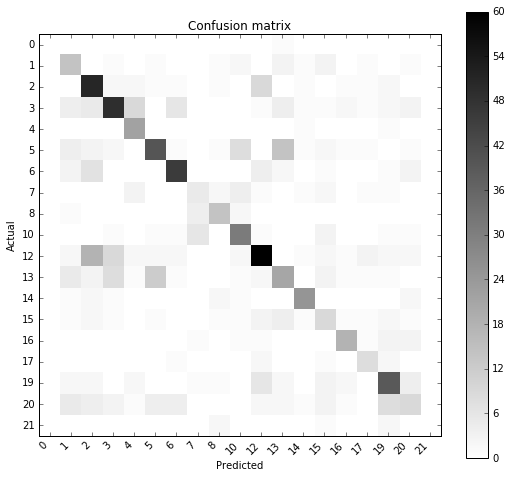

In [192]:
cm = ConfusionMatrix(cap_results['manual'], cap_results['topic1'])
cm.print_stats()
#print cm
cm.plot()

In [196]:
def print_performance(actual, predicted):
    print 'accuracy', accuracy_score(actual, predicted)
    print 'precision', precision_score(actual, predicted)
    print 'recall', recall_score(actual, predicted)
    print 'F1 (microaveraged)', f1_score(actual, predicted, average='micro')
    print 'F1 (macroaveraged)', f1_score(actual, predicted, average='macro')
    print

print_performance(cap_results['manual'], cap_results['topic1'])
print_performance(cap_results['manual'], cap_results['topicmodeling1'].fillna(0))

 accuracy 0.552095808383
precision 0.553688776611
recall 0.552095808383
F1 (microaveraged) 0.552095808383
F1 (macroaveraged) 0.473370243552

accuracy 0.468263473054
precision 0.602374444101
recall 0.468263473054
F1 (microaveraged) 0.468263473054
F1 (macroaveraged) 0.404357439079



/home/jvdzwaan/.local/lib/python2.7/site-packages/sklearn/metrics/metrics.py:1773: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/jvdzwaan/.local/lib/python2.7/site-packages/sklearn/metrics/metrics.py:1773: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [216]:
# Are all CAP categories present in the topics?
from collections import Counter

c = Counter()
d = {}
for topic, cap in topic2cap.iteritems():
    c[cap] += 1
    if not cap in d.keys():
        d[cap] = []
    d[cap].append(topic)
print c.keys()

manual = dict(cap_results['manual'].value_counts())
del manual[0]
print manual.keys()

[1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15, 16, 17, 19, 20, 21]
[1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15, 16, 17, 19, 20, 21]


In [217]:
topic_cap_mapping = pd.concat([pd.Series(manual), pd.Series(d), pd.Series(c)], axis=1)
topic_cap_mapping.columns = ['number of texts', 'topics numbers', 'number of topics']

topic_cap_mapping

,number of texts,topics numbers,number of topics
1,28,"[38, 44, 48, 97]",4
2,72,"[32, 33, 40, 45, 57, 62, 63, 82, 98]",9
3,88,"[1, 5, 7, 21, 23, 58, 81, 83, 94]",9
4,24,"[26, 37, 56]",3
5,79,"[22, 25, 59]",3
6,67,"[12, 30, 49, 66, 80, 96]",6
7,20,"[46, 85]",2
8,21,"[67, 68, 78]",3
10,46,"[4, 6, 84, 87]",4
12,108,"[16, 17, 24, 55, 74, 76, 90, 92, 95]",9


In [221]:
c = Counter()
hq = {}
for i, h in enumerate(usefulness_data['mean_usefulness'] > 2.0):
    if h:
        cap = topic2cap[i]
        c[cap] += 1
        if not cap in hq.keys():
            hq[cap] = []
        hq[cap].append(i)
print hq.keys()

hq[21] = []
c[21] = 0

topic_cap_mapping['high quality topics'] = pd.Series(hq)
topic_cap_mapping['number of high quality topics'] = pd.Series(c)
topic_cap_mapping

[1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15, 16, 17, 19, 20]


,number of texts,topics numbers,number of topics,high quality topics,number of high quality topics
1,28,"[38, 44, 48, 97]",4,"[38, 44, 97]",3
2,72,"[32, 33, 40, 45, 57, 62, 63, 82, 98]",9,"[32, 33, 40, 98]",4
3,88,"[1, 5, 7, 21, 23, 58, 81, 83, 94]",9,"[1, 5, 7, 21, 23, 58, 81, 83, 94]",9
4,24,"[26, 37, 56]",3,"[26, 37, 56]",3
5,79,"[22, 25, 59]",3,"[22, 25, 59]",3
6,67,"[12, 30, 49, 66, 80, 96]",6,"[30, 49, 66, 96]",4
7,20,"[46, 85]",2,[46],1
8,21,"[67, 68, 78]",3,[78],1
10,46,"[4, 6, 84, 87]",4,"[4, 87]",2
12,108,"[16, 17, 24, 55, 74, 76, 90, 92, 95]",9,"[17, 24, 55, 76, 92, 95]",6


In [234]:
topic_cap_mapping['percentage of texts'] = topic_cap_mapping.apply(lambda row: float(row['number of texts'])/np.sum(topic_cap_mapping['number of texts']) * 100.0, axis=1)

In [235]:
pred = dict(cap_results['topic1'].value_counts())
pred[21] = 0
topic_cap_mapping['number texts predicted'] = pd.Series(pred)
topic_cap_mapping

,number of texts,topics numbers,number of topics,high quality topics,number of high quality topics,percentage of texts,number texts predicted
1,28,"[38, 44, 48, 97]",4,"[38, 44, 97]",3,3.357314,42
2,72,"[32, 33, 40, 45, 57, 62, 63, 82, 98]",9,"[32, 33, 40, 98]",4,8.633094,97
3,88,"[1, 5, 7, 21, 23, 58, 81, 83, 94]",9,"[1, 5, 7, 21, 23, 58, 81, 83, 94]",9,10.551559,77
4,24,"[26, 37, 56]",3,"[26, 37, 56]",3,2.877698,42
5,79,"[22, 25, 59]",3,"[22, 25, 59]",3,9.472422,62
6,67,"[12, 30, 49, 66, 80, 96]",6,"[30, 49, 66, 96]",4,8.033573,63
7,20,"[46, 85]",2,[46],1,2.398082,17
8,21,"[67, 68, 78]",3,[78],1,2.517986,25
10,46,"[4, 6, 84, 87]",4,"[4, 87]",2,5.515588,53
12,108,"[16, 17, 24, 55, 74, 76, 90, 92, 95]",9,"[17, 24, 55, 76, 92, 95]",6,12.949640,92


In [237]:
import glob

d = pd.read_csv('/home/jvdzwaan/data/dilipad/CAP/thetas/theta_100_0.csv', index_col=0)
res = pd.DataFrame(index=d.index)

files = glob.glob('/home/jvdzwaan/data/dilipad/CAP/thetas/*_*_*.csv')
#print files
for i, fi in enumerate(files):
    df = pd.read_csv(fi, index_col=0)
    res[i] = df.apply(lambda row: top10(row, 1), axis=1)
#print topic2cap
res[['cap{}'.format(i) for i in range(10)]] = res.apply(lambda series: [topic2cap[int(v)] for v in series])
res

,0,1,2,3,4,5,6,7,8,9,cap0,cap1,cap2,cap3,cap4,cap5,cap6,cap7,cap8,cap9
1000.txt,83,83,83,83,83,83,83,83,83,83,3,3,3,3,3,3,3,3,3,3
1001.txt,87,87,87,87,87,87,87,87,87,87,10,10,10,10,10,10,10,10,10,10
1002.txt,58,58,58,58,58,58,58,58,58,58,3,3,3,3,3,3,3,3,3,3
1003.txt,71,71,71,71,71,71,71,5,71,71,13,13,13,13,13,13,13,3,13,13
1004.txt,26,26,26,26,26,26,26,26,26,26,4,4,4,4,4,4,4,4,4,4
1005.txt,87,87,87,87,87,87,87,87,87,87,10,10,10,10,10,10,10,10,10,10
1006.txt,97,53,97,97,97,97,97,23,97,53,1,14,1,1,1,1,1,3,1,14
1007.txt,21,21,21,21,21,21,21,21,21,21,3,3,3,3,3,3,3,3,3,3
1008.txt,25,25,25,25,25,25,25,25,25,25,5,5,5,5,5,5,5,5,5,5
1009.txt,61,61,61,61,61,61,61,61,61,61,17,17,17,17,17,17,17,17,17,17


In [247]:
res['manual'] = pd.Series(data=cap_results['manual'].values, index=cap_results['Unnamed: 0'].values)
res

,0,1,2,3,4,5,6,7,8,9,...,cap1,cap2,cap3,cap4,cap5,cap6,cap7,cap8,cap9,manual
1000.txt,83,83,83,83,83,83,83,83,83,83,...,3,3,3,3,3,3,3,3,3,3
1001.txt,87,87,87,87,87,87,87,87,87,87,...,10,10,10,10,10,10,10,10,10,10
1002.txt,58,58,58,58,58,58,58,58,58,58,...,3,3,3,3,3,3,3,3,3,12
1003.txt,71,71,71,71,71,71,71,5,71,71,...,13,13,13,13,13,13,3,13,13,13
1004.txt,26,26,26,26,26,26,26,26,26,26,...,4,4,4,4,4,4,4,4,4,4
1005.txt,87,87,87,87,87,87,87,87,87,87,...,10,10,10,10,10,10,10,10,10,10
1006.txt,97,53,97,97,97,97,97,23,97,53,...,14,1,1,1,1,1,3,1,14,20
1007.txt,21,21,21,21,21,21,21,21,21,21,...,3,3,3,3,3,3,3,3,3,3
1008.txt,25,25,25,25,25,25,25,25,25,25,...,5,5,5,5,5,5,5,5,5,5
1009.txt,61,61,61,61,61,61,61,61,61,61,...,17,17,17,17,17,17,17,17,17,12


In [275]:
performance = pd.DataFrame(np.zeros((5, 4)), columns=['accuracy', 'precision', 'recall', 'F1'], index=range(5))

for it in range(10):
    performance.loc[it, 'accuracy'] = accuracy_score(res['manual'], res['cap{}'.format(it)])
    performance.loc[it, 'precision'] = precision_score(res['manual'], res['cap{}'.format(it)], average='weighted')
    performance.loc[it, 'recall'] = recall_score(res['manual'], res['cap{}'.format(it)], average='weighted')
    performance.loc[it, 'F1'] = f1_score(res['manual'], res['cap{}'.format(it)], average='weighted')
    
performance.to_csv('/home/jvdzwaan/data/dilipad/CAP/performance_tm.csv', encoding='utf-8')
performance

,accuracy,precision,recall,F1
0,0.542515,0.545878,0.542515,0.537293
1,0.543713,0.550821,0.543713,0.540567
2,0.564072,0.573709,0.564072,0.563727
3,0.548503,0.553163,0.548503,0.544731
4,0.561677,0.566698,0.561677,0.560121
5,0.547305,0.549761,0.547305,0.543093
6,0.550898,0.563701,0.550898,0.551428
7,0.550898,0.558994,0.550898,0.550634
8,0.540120,0.550718,0.540120,0.539723
9,0.544910,0.552111,0.544910,0.542543
